## iSAX class implementation

In [2]:
import numpy as np
from scipy.stats import norm

class iSAX:
    def __init__(self, word_length, cardinality):
        # Initialize iSAX with word length and cardinality
        self.word_length = word_length
        self.cardinality = cardinality
        self.breakpoints = self.generate_breakpoints(cardinality)
        
    

    def generate_breakpoints(self, cardinality):
        """Generate breakpoints for iSAX using the inverse CDF of a standard normal distribution."""
        return [norm.ppf(i / cardinality) for i in range(1, cardinality)]

    def normalize(self, time_series):
        """Normalize the time series."""
        mean = np.mean(time_series)
        std = np.std(time_series)
        if std == 0:
            return np.zeros_like(time_series)  # Return zeros if standard deviation is zero
        return (time_series - mean) / std # Normalize values

    def paa(self, ts):
        paa_size = self.word_length # Number of segments
        length = len(ts) # Length of time series
        
        if length == paa_size:
            return np.array(ts) # If already the correct length, return as is
        
        if length % paa_size == 0:
            return np.mean(np.reshape(ts, (paa_size, -1)), axis=1) # Direct reshaping case
        
        res = np.zeros(paa_size) # Initialize result array
        for i in range(length * paa_size):
            idx = i // length  # Determine PAA segment index
            pos = i // paa_size  # Determine time series index
            res[idx] += ts[pos]
        
        return res / length  # Normalize result
    
    def to_isax(self, paa_segments):
        """Convert PAA to iSAX symbols."""
        sax_word = [] # Initialize iSAX word list
        for segment in paa_segments:
            for i, bp in enumerate(self.breakpoints):
                if segment <= bp:
                    sax_word.append(len(self.breakpoints) - i) # Assign symbol based on breakpoints
                    break
            else:
                # If the segment is greater than all breakpoints, assign the last symbol
                sax_word.append(0)
        return sax_word

    def symbol_distance(self, s1, s2, bps):
        """
            Compute the distance between two SAX symbols using the breakpoints.
            If the symbols are equal or adjacent (|s1-s2| <= 1), the distance is 0.
            Otherwise, it is defined as:
                distance = |bps[max(s1,s2)] - bps[min(s1,s2)+1]|
        """
        if abs(s1 - s2) <= 1:
            return 0.0 # No distance if symbols are the same or adjacent
        else:
            lower = bps[min(s1, s2) + 1] # Get lower breakpoint
            upper = bps[max(s1, s2)] # Get upper breakpoint
            return abs(upper - lower) # Compute absolute difference

    def mindist(self, sax1, sax2, bps, n, w):
        """
            Compute the SAX lower bound distance (MINDIST) between two SAX representations.
            MINDIST = sqrt((n / w) * sum_i (symbol_distance(sax1[i], sax2[i], bps))^2)
        """
        bps = [-np.inf] + bps + [np.inf] # Extend breakpoints with infinity bounds
        sum_sq = 0.0  # Initialize sum of squared distances
        for i in range(w):
            d = self.symbol_distance(sax1[i], sax2[i], bps) # Compute symbol distance
            sum_sq += d ** 2 # Accumulate squared distance
        return np.sqrt((n / w) * sum_sq) # Compute final distance

## Figure 2 & 3 from iSAX paper -- recreation

Breakpoints: [np.float64(-1.1503493803760079), np.float64(-0.6744897501960817), np.float64(-0.31863936396437514), np.float64(0.0), np.float64(0.31863936396437514), np.float64(0.6744897501960817), np.float64(1.1503493803760079)]
PAA Segments: [-0.6825 -0.84    0.205   1.7125]
iSAX Word: [6, 6, 3, 0]


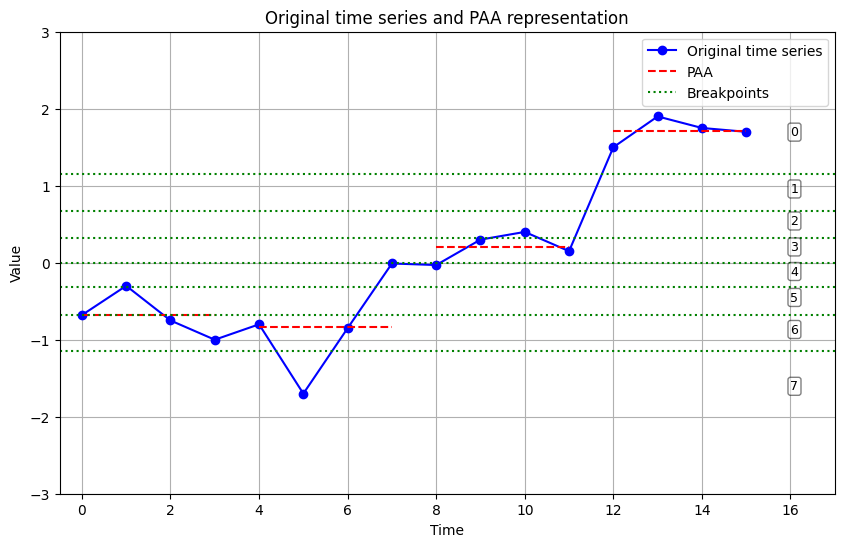

In [5]:
import matplotlib.pyplot as plt
# Reconstructed time series from Figure 2
T = [-0.68, -0.3, -0.75, -1, -0.8, -1.7, -0.85, -0.01, -0.03, 0.3, 0.4, 0.15, 1.5, 1.9, 1.75, 1.7]

# Initialize iSAX with word_length = 4 and cardinality = 8
isax = iSAX(word_length = 4, cardinality = 8)

# Compute PAA
paa_segments = isax.paa(T)

# Convert PAA to SAX
isax_word = isax.to_isax(paa_segments)

print("Breakpoints:", isax.breakpoints)
print("PAA Segments:", paa_segments)
print("iSAX Word:", isax_word)


plt.figure(figsize=(10, 6))

# Plot the original time series
plt.plot(T, label = "Original time series", color = "blue", marker = "o")

# Plot the PAA representation
for i, paa_value in enumerate(paa_segments):
    start = i * (len(T) // isax.word_length)
    end = (i + 1) * (len(T) // isax.word_length) - 1
    plt.hlines(paa_value, start, end, colors = "red", linestyles = "dashed", label = f"PAA" if i == 0 else "")

# Plot the breakpoints
for bp in isax.breakpoints:
    plt.axhline(y = bp, color = "green", linestyle = "dotted", label = f"Breakpoints" if bp == isax.breakpoints[0] else "") 

all_breakpoints = [-np.inf] + list(isax.breakpoints) + [np.inf]  # Add min/max regions

# Calculate proper midpoints for each region
region_positions = []
for i in range(len(all_breakpoints) - 1):
    if np.isinf(all_breakpoints[i]):  # Region below min breakpoint
        region_positions.append(all_breakpoints[i + 1] - 0.5)
    elif np.isinf(all_breakpoints[i + 1]):  # Region above max breakpoint
        region_positions.append(all_breakpoints[i] + 0.5)
    else:  # Regular regions between breakpoints
        region_positions.append((all_breakpoints[i] + all_breakpoints[i + 1]) / 2)

# Plot region numbers at appropriate y-values
for i, pos in enumerate(region_positions):
    plt.text(len(T) , pos, str(len(region_positions) - i - 1), fontsize=9, color="black", 
             bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.2'))
    
# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.ylim([-3, 3])
plt.xlim([-0.5,17])
plt.title("Original time series and PAA representation")
plt.legend()
plt.grid()
plt.savefig("breakpoints.pdf", format = 'pdf')
plt.show()

## Table 2 from iSAX paper -- breakpoints recreation

In [6]:
cardinalities = [2, 3, 4, 5, 6, 7, 8]

# Generate breakpoints for each cardinality
breakpoints_list = []
for a in cardinalities:
    isax = iSAX(word_length=4, cardinality=a)
    breakpoints = [f"{bp:>6.2f}" for bp in isax.breakpoints]  # Right-align numbers
    breakpoints_list.append(breakpoints)

# Find the max number of breakpoints to label them correctly
max_breakpoints = max(len(bp) for bp in breakpoints_list)

# Print header row with cardinalities
header_row = " | ".join(f"{a:^6}" for a in cardinalities)
print(f"   {'Cardinality':^50}")
print(f"   {header_row}")
print("—" * (8 * len(cardinalities) + 7))  # Creates a separator

# Print each row of breakpoints with labels (β₁, β₂, ...)
for i in range(max_breakpoints):
    row = []
    for bp in breakpoints_list:
        row.append(bp[i] if i < len(bp) else "      ")  # Fill missing spots with spaces
    print(f"β{i+1} " + " | ".join(row))  # Label the row with β₁, β₂, ...

                      Cardinality                    
     2    |   3    |   4    |   5    |   6    |   7    |   8   
———————————————————————————————————————————————————————————————
β1   0.00 |  -0.43 |  -0.67 |  -0.84 |  -0.97 |  -1.07 |  -1.15
β2        |   0.43 |   0.00 |  -0.25 |  -0.43 |  -0.57 |  -0.67
β3        |        |   0.67 |   0.25 |   0.00 |  -0.18 |  -0.32
β4        |        |        |   0.84 |   0.43 |   0.18 |   0.00
β5        |        |        |        |   0.97 |   0.57 |   0.32
β6        |        |        |        |        |   1.07 |   0.67
β7        |        |        |        |        |        |   1.15


## Figure 4 from iSAX paper -- recreation

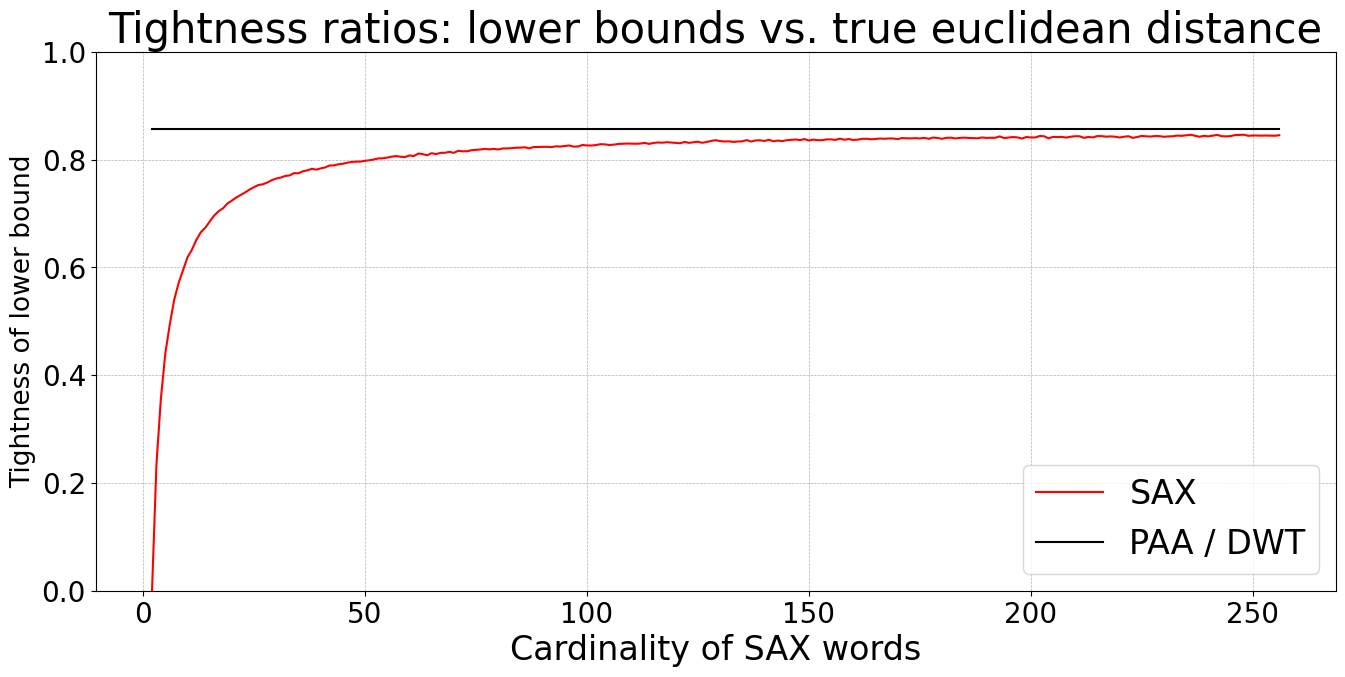

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# --- Utility Functions ---

def random_walk(n):
    """Generate a random walk time series of length n."""
    increments = np.random.normal(loc=0, scale=1, size=n)
    return np.cumsum(increments)

def z_normalize(ts):
    """Z-normalize a time series."""
    mean = np.mean(ts)
    std = np.std(ts)
    return (ts - mean) / std if std > 0 else ts

def paa_distance(paa1, paa2, n, w):
    """
        Compute the PAA distance between two PAA representations:
        d_PAA = sqrt((n / w) * sum((paa1 - paa2)^2))
    """
    return np.sqrt((n / w) * np.sum((paa1 - paa2) ** 2))

# --- Experiment: compute tightness ratios ---

# Experiment parameters
n = 256             # Length of each time series
w = 8               # Number of segments (PAA/SAX word length)
num_pairs = 10000   # Number of random walk pairs for averaging

# List of SAX cardinalities to test
cardinalities = [i for i in range(2, 257)]

# Lists to hold average tightness ratios:
#   ratio_PAA = PAA_distance / Euclidean_distance
#   ratio_MINDIST = MINDIST_SAX / Euclidean_distance
avg_ratio_paa = []
avg_ratio_mindist = []

for a in cardinalities:
    ratios_paa = []
    ratios_sax = []
    isax = iSAX(w, a)
    for _ in range(num_pairs):
        # Generate two random walk time series and z-normalize them
        ts1 = z_normalize(random_walk(n))
        ts2 = z_normalize(random_walk(n))
        
        # Compute the true Euclidean distance between the two normalized time series
        true_dist = np.linalg.norm(ts1 - ts2)
        
        # Compute PAA representations
        paa1 = isax.paa(ts1)
        paa2 = isax.paa(ts2)
        
        # Compute the PAA distance
        d_paa = paa_distance(paa1, paa2, n, w)
        ratio_paa = d_paa / true_dist if true_dist > 0 else 0
        
        # Compute the SAX representations
        sax1 = isax.to_isax(paa1)
        sax2 = isax.to_isax(paa2)
        bps = isax.breakpoints
        
        # Compute the SAX lower bound (MINDIST)
        d_sax = isax.mindist(sax1, sax2, bps, n, w)
        ratio_sax = d_sax / true_dist if true_dist > 0 else 0
        
        ratios_paa.append(ratio_paa)
        ratios_sax.append(ratio_sax)
    
    avg_ratio_paa.append(np.mean(ratios_paa))
    avg_ratio_mindist.append(np.mean(ratios_sax))
    # print(f"Cardinality: {a:3d} | Avg PAA/Euclidean: {np.mean(ratios_paa):.4f} | Avg MINDIST/Euclidean: {np.mean(ratios_sax):.4f}")
    
# --- Plot the Results ---
plt.figure(figsize=(16, 7))
plt.plot(cardinalities, avg_ratio_mindist, color = 'r', label='SAX')
plt.plot(cardinalities, np.full(len(cardinalities), np.mean(avg_ratio_paa)), color = 'black', label='PAA / DWT')
plt.xlabel('Cardinality of SAX words', fontsize = 24)
plt.ylabel('Tightness of lower bound', fontsize = 19)
plt.ylim([0.0, 1.0])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.title('Tightness ratios: lower bounds vs. true euclidean distance', fontsize = 30)
plt.legend(fontsize = 24)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig("tightness.pdf", format='pdf')
plt.show()


## Figure 6 from iSAX paper -- recreation

Load the ECG Dataset from the URL

In [8]:
import numpy as np
import requests

# Load the ECG dataset from the URL
def load_ecg_dataset(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Load the dataset
        from io import StringIO
        data = StringIO(response.text)
        ecg_dataset = np.loadtxt(data)  # Automatically parses the text into a NumPy array
        return ecg_dataset
    else:
        raise Exception(f"Failed to load dataset from {url}")

# URL of the ECG dataset
url = "https://www.cs.ucr.edu/~eamonn/iSAX/koski_ecg.dat"
ecg_dataset = load_ecg_dataset(url)

print(f"Loaded {ecg_dataset.shape[0]} data points.")


Loaded 144002 data points.


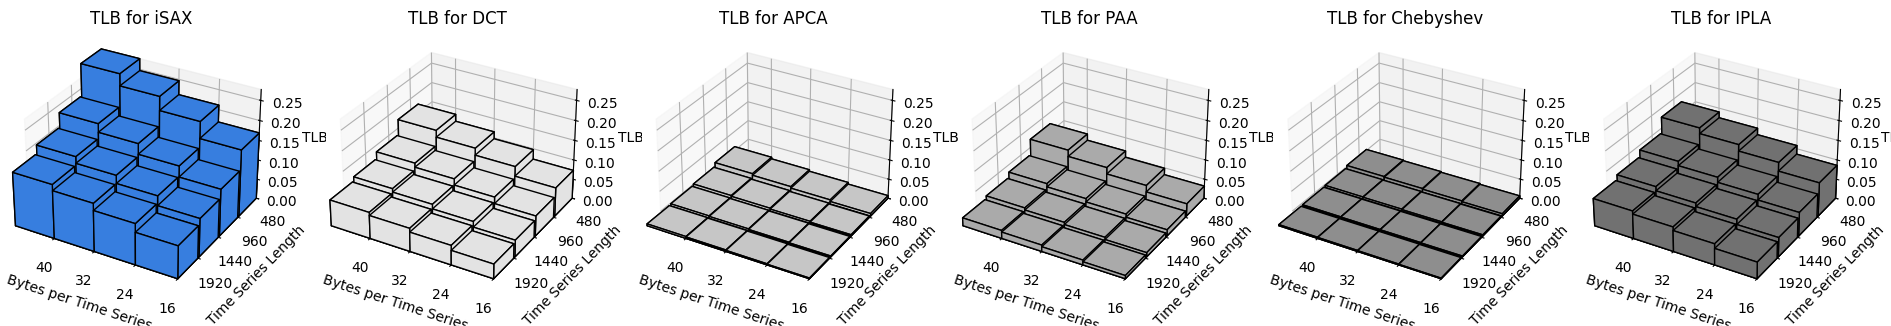

In [104]:
from scipy.fftpack import fft, dct
from numpy.polynomial.chebyshev import chebfit

# Other methods for time series representation

def dct_transform(ts, w):
    """Discrete Cosine Transform (DCT) of the time series."""
    return dct(ts, norm='ortho')[:w]


def apca(ts, w):
    """Adaptive Piecewise Constant Approximation (APCA) of the time series."""
    segments = np.array_split(ts, w)
    return np.array([np.mean(segment) for segment in segments])

def ipla(ts, w):
    """Indexable Piecewise Linear Approximation (IPLA) of the time series."""
    indices = np.linspace(0, len(ts) - 1, w, dtype=int)
    return ts[indices]


def chebyshev_transform(ts, w):
    """Chebyshev Polynomials of the time series."""
    return chebfit(np.linspace(-1, 1, len(ts)), ts, w - 1)

num_samples = 1000

# We will compute the tightness ratios for the following methods
# iSAX, DCT, APCA, PAA, Chebyshev, and IPLA
def compute_tlb(ecg_dataset, time_series_lengths, bytes_per_ts_list, num_samples=1000):
    tlb_results = {method: np.zeros((len(time_series_lengths), len(bytes_per_ts_list))) for method in methods}
    
    for i, ts_length in enumerate(time_series_lengths):
        for j, bytes_per_ts in enumerate(bytes_per_ts_list):
            tlb_sum = {method: 0.0 for method in methods}
            
            for _ in range(num_samples):
                time_series = np.random.choice(ecg_dataset, 2 * ts_length, replace=True)
                ts1 = time_series[:ts_length]
                ts2 = time_series[ts_length:]
                ts1_norm, ts2_norm = z_normalize(ts1), z_normalize(ts2)
                
                # Compute representations for both time series
                representations_ts1 = {}
                representations_ts2 = {}
                
                # For iSAX, hardcode cardinality to 256 and set word length = bytes_per_ts
                sax = iSAX(word_length=bytes_per_ts, cardinality=256)
                representations_ts1["iSAX"] = sax.to_isax(sax.paa(ts1_norm))
                representations_ts2["iSAX"] = sax.to_isax(sax.paa(ts2_norm))
                
                representations_ts1["DCT"] = dct_transform(ts1_norm, bytes_per_ts // 4)
                representations_ts2["DCT"] = dct_transform(ts2_norm, bytes_per_ts // 4)
                
                representations_ts1["PAA"] = sax.paa(ts1_norm)
                representations_ts2["PAA"] = sax.paa(ts2_norm)
                
                representations_ts1["Chebyshev"] = chebyshev_transform(ts1_norm, bytes_per_ts // 4)
                representations_ts2["Chebyshev"] = chebyshev_transform(ts2_norm, bytes_per_ts // 4)
                
                representations_ts1["APCA"] = apca(ts1_norm, bytes_per_ts // 4)
                representations_ts2["APCA"] = apca(ts2_norm, bytes_per_ts // 4)

                representations_ts1["IPLA"] = ipla(ts1_norm, bytes_per_ts // 4)
                representations_ts2["IPLA"] = ipla(ts2_norm, bytes_per_ts // 4)
                
                true_dist = np.linalg.norm(ts1_norm - ts2_norm)
                for method in methods:
                    if method == "iSAX":
                        # For iSAX, use the MINDIST function
                        lower_bound = sax.mindist(representations_ts1[method], representations_ts2[method], sax.breakpoints, ts_length, bytes_per_ts)
                    else:
                        # For other methods, use Euclidean distance on the representations
                        lower_bound = np.linalg.norm(np.array(representations_ts1[method]) - np.array(representations_ts2[method]))
                    tlb_sum[method] += lower_bound / true_dist if true_dist > 0 else 0
            
            # Average TLB over 1,000 samples for each method
            for method in methods:
                tlb_results[method][i, j] = tlb_sum[method] / num_samples
    
    return tlb_results

# Parameters
time_series_lengths = [1920, 1440, 960, 480]
bytes_per_ts_list = [16, 24, 32, 40]
methods = ["iSAX", "DCT", "APCA", "PAA", "Chebyshev",  "IPLA"]

tlb_results = compute_tlb(ecg_dataset, time_series_lengths, bytes_per_ts_list, num_samples=1000)

fig = plt.figure(figsize=(36, 6))

dx = 8
dy = 450

# Colors for the plots
colors = ['#377EDF', '#E3E3E3', '#C6C6C6', '#AAAAAA', '#8E8E8E', '#717171']

for idx, method in enumerate(methods):
    ax = fig.add_subplot(1, 9, idx + 1, projection='3d')

    X, Y = np.meshgrid(bytes_per_ts_list, time_series_lengths)
    Z = tlb_results[method]
    if idx == 0:
        Z_max = Z

    X, Y, Z = X.ravel(), Y.ravel(), Z.ravel()

    ax.bar3d(X, Y, np.zeros_like(Z), dx, dy, Z, shade=False, cmap='viridis', edgecolor='black', color = colors[idx])
    ax.set_xlim([max(bytes_per_ts_list)+ 5, min(bytes_per_ts_list)])
    ax.set_ylim([max(time_series_lengths) + dy + 1, min(time_series_lengths) ])
    ax.set_zlim([0.0, np.max(Z_max)])

    ax.set_xticks(bytes_per_ts_list)
    ax.set_xticklabels([str(b) for b in bytes_per_ts_list])

    ax.set_yticks(time_series_lengths)
    ax.set_yticklabels([str(t) for t in time_series_lengths])

    

    ax.set_xlabel('Bytes per Time Series')
    ax.set_ylabel('Time Series Length')
    ax.set_zlabel('TLB')
    ax.set_title(f'TLB for {method}')

plt.savefig("exp1_rep.pdf", format='pdf')
plt.show()

## Figure 8 from iSAX paper -- recreation
First, we implement the iSAX structure with node splitting.

In [1]:
import numpy as np
import os
import heapq

class iSAXNode:
    def __init__(self, is_leaf=True, isax_word=None, cardinalities=None, word_length=8, base_dir="data"):

        self.is_leaf = is_leaf
        self.isax_word = isax_word  # Store iSAX representation
        self.cardinalities = cardinalities if cardinalities else [4] * word_length  # Per-dimension cardinalities
        self.word_length = word_length
        self.children = {}  # Dictionary of children nodes
        self.base_dir = base_dir
        self.file_path = self._get_file_path() if is_leaf else None
        if self.file_path and not os.path.exists(base_dir):
            os.makedirs(base_dir)

    def is_full(self):
        """Check if the node has exceeded the threshold."""
        with open(self.file_path, 'r') as f:
            return sum(1 for _ in f) >= self.threshold

    def _write_to_file(self, time_series):
        """Write a time series to the node's file."""
        with open(self.file_path, 'a') as f:
            f.write(','.join(map(str, time_series)) + '\n')

    def _get_file_path(self):
        """Generate a file path based on the iSAX word."""
        file_name = '_'.join(f"{symbol}_{cardinality}" for symbol, cardinality in self.isax_word) + '.txt'
        return os.path.join(self.base_dir, file_name)

# Define the iSAX index structure
class iSAXIndex:
    def __init__(self, word_length=8, base_cardinality=4, threshold=100):
        self.word_length = word_length # Length of the iSAX word
        self.base_cardinality = base_cardinality # Base cardinality for each dimension
        self.threshold = threshold # Maximum number of time series in a leaf node
        self.root = iSAXNode(word_length=word_length, cardinalities=[base_cardinality] * word_length, is_leaf=False) # Initialize the root node
        self.hash_table = {}  # Store mapping of iSAX words to nodes
        self.split_counter = 0  # Counter for splitting nodes
    
    # --- iSAX Methods ---

    def _get_breakpoints(self, cardinality):
        """Generate breakpoints for iSAX using the inverse CDF of a standard normal distribution."""
        return [norm.ppf(i / cardinality) for i in range(1, cardinality)]

    def _value_to_symbol(self, value, cardinality):
        """Map a PAA value to an iSAX symbol using breakpoints."""
        breakpoints = self._get_breakpoints(cardinality)
        for i, bp in enumerate(breakpoints):
            if value <= bp:
                return len(breakpoints) - i
        return 0

    def sax_transform(self, paa, cardinalities):
        """Convert a time series to its iSAX representation."""
        # Map PAA values to iSAX symbols using breakpoints
        isax_word = []
        for i, cardinality in enumerate(cardinalities):
            value = paa[i]
            symbol = self._value_to_symbol(value, cardinality)
            isax_word.append((symbol, cardinality))
        return tuple(isax_word)

    def paa_transform(self, ts, word_length):
        paa_size = word_length
        length = len(ts)
        
        if length == paa_size:
            return np.array(ts)
        
        if length % paa_size == 0:
            return np.mean(np.reshape(ts, (paa_size, -1)), axis=1)
        
        res = np.zeros(paa_size)
        for i in range(length * paa_size):
            idx = i // length  # the spot
            pos = i // paa_size  # the col spot
            res[idx] += ts[pos]
        
        return res / length
    
    def insert(self, time_series):
        """Insert a time series into the iSAX index using hierarchical insertion."""
        paa_values = self.paa_transform(time_series, self.word_length)
        sax_word = tuple(self.sax_transform(paa_values, self.root.cardinalities))
        
        node = self.root
        while not node.is_leaf:
            if sax_word not in node.children:
                node.children[sax_word] = iSAXNode(isax_word=sax_word, cardinalities=node.cardinalities, word_length=node.word_length)
            node = node.children[sax_word]
        
        if len(self._read_file(node.file_path)) >= self.threshold:
            self.split_node(node)
            self.insert(time_series)  # Reinsert the series into the correct node after split
        else:
            node._write_to_file(time_series)
    
    def split_node(self, node):
        """Split a leaf node by increasing resolution on one dimension."""
        node.is_leaf = False

        split_dim = self.split_counter % self.word_length
        self.split_counter += 1  # Move to the next dimension for the next split - Round-robin strategy

        new_cardinalities = node.cardinalities[:]
        new_cardinalities[split_dim] *= 2  # Increase resolution only in one dimension
        
        new_children = {}
        
        for series in self._read_file(node.file_path):
            paa_values = self.paa_transform(series, node.word_length)
            new_sax_word = tuple(self.sax_transform(paa_values, new_cardinalities))
            
            if new_sax_word not in new_children:
                new_children[new_sax_word] = iSAXNode(isax_word=new_sax_word, cardinalities=new_cardinalities, word_length=node.word_length)
            new_children[new_sax_word]._write_to_file(series)
        
        node.children = new_children
        os.remove(node.file_path)  # Remove the old file after redistribution

    def _read_file(self, file_path):
        """Read time series data from a file."""
        if os.path.exists(file_path):
            with open(file_path, "r") as f:
                return [list(map(float, line.strip().split(','))) for line in f]
        return []
    
    def approximate_search(self, query_series):
        """Perform an approximate search by finding the closest leaf node."""
        paa_values = self.paa_transform(query_series, self.word_length)
        query_isax = tuple(self.sax_transform(paa_values, self.root.cardinalities))

        # Traverse the tree to find the closest matching leaf node
        node = self.root
        while not node.is_leaf:
            if query_isax in node.children:
                node = node.children[query_isax]
            else:
                # Choose the closest available node
                best_match = min(node.children.keys(), key=lambda k: self._mindist_isax(query_isax, k, self.word_length))
                node = node.children[best_match]

        # Retrieve time series from the matched node
        candidates = self._read_file(node.file_path)
        if not candidates:
            return None  # No candidates found
        
        # Perform a simple linear scan to find the best match
        best_match = min(candidates, key=lambda ts: np.linalg.norm(np.array(ts) - np.array(query_series)))
        return best_match
    
    def true_nearest_neighbor(self, query_series):
        """Perform an exact search to find the true nearest neighbor in the index."""
        paa_values = self.paa_transform(query_series, self.word_length)
        query_isax = tuple(self.sax_transform(paa_values, self.root.cardinalities))
        
        best_match = None
        best_distance = float("inf")
        
        # Min-heap for priority-based search
        priority_queue = [(0, id(self.root), self.root)]

        while priority_queue:
            _, _, node = heapq.heappop(priority_queue)

            if node.is_leaf:
                # Fetch stored time series and compute Euclidean distance
                candidates = self._read_file(node.file_path)
                for ts in candidates:
                    dist = np.linalg.norm(np.array(ts) - np.array(query_series))
                    if dist < best_distance:
                        best_distance = dist
                        best_match = ts
            else:
                # Push children to priority queue, ordered by lower bound distance
                for child_isax, child in node.children.items():
                    lb_distance = self._mindist_isax(query_isax, child_isax, self.word_length)
                    if lb_distance < best_distance:  # Prune if not promising
                        heapq.heappush(priority_queue, (lb_distance, id(child), child))

        return best_match, best_distance  # Return the nearest time series and distance


    def _mindist_isax(self, word1, word2, word_length):
        """
            Compute the lower-bounding distance (MINDIST) between two iSAX words, even with different cardinalities based on Equation (5) of Section 4.2.
        """
        total_dist = 0.0
        
        for (symbol1, cardinality1), (symbol2, cardinality2) in zip(word1, word2):
            # Ensure both words have the same cardinality by promoting the lower one
            max_cardinality = max(cardinality1, cardinality2)

            # Get breakpoints for both symbols at the max cardinality
            breakpoints = self._get_breakpoints(max_cardinality)

            # Map symbols to breakpoints
            beta_lower = breakpoints[symbol1] if symbol1 < len(breakpoints) else breakpoints[-1]
            beta_upper = breakpoints[symbol2] if symbol2 < len(breakpoints) else breakpoints[-1]

            # Accumulate squared distance
            total_dist += (beta_lower - beta_upper) ** 2

        return np.sqrt(total_dist)

Experimental setup.


=== Running Experiment for Dataset Size: 100000 ===
Processing Query 0/1000...
Processing Query 100/1000...
Processing Query 200/1000...
Processing Query 300/1000...
Processing Query 400/1000...
Processing Query 500/1000...
Processing Query 600/1000...
Processing Query 700/1000...
Processing Query 800/1000...
Processing Query 900/1000...
Time taken for dataset size 100000: 16291.57 seconds
Deleted directory: data

=== Running Experiment for Dataset Size: 200000 ===
Processing Query 0/1000...
Processing Query 100/1000...
Processing Query 200/1000...
Processing Query 300/1000...
Processing Query 400/1000...
Processing Query 500/1000...
Processing Query 600/1000...
Processing Query 700/1000...
Processing Query 800/1000...
Processing Query 900/1000...
Time taken for dataset size 200000: 25616.20 seconds
Deleted directory: data

=== Running Experiment for Dataset Size: 400000 ===
Processing Query 0/1000...
Processing Query 100/1000...
Processing Query 200/1000...
Processing Query 300/1000.

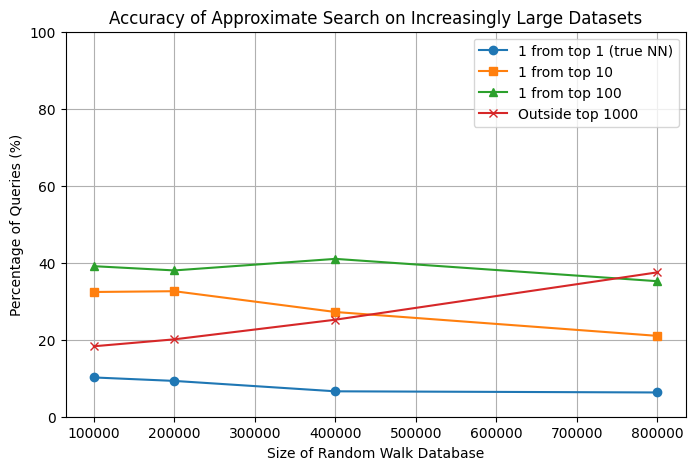

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import shutil
from scipy.stats import norm

# Parameters
b = 4     # Base cardinality
w = 8     # Word length (segments)
th = 100  # Threshold for splitting nodes in iSAX index

# Generate and normalize Random Walk Time Series
def generate_random_walk(length, num_series):
    """Generate multiple random walk time series and z-normalize them."""
    walks = np.cumsum(np.random.randn(num_series, length), axis=1)
    return np.array([(series - np.mean(series)) / np.std(series) for series in walks])


# Create an iSAX Database
def create_isax_database(size, series_length):
    """Create an iSAX index and insert random walk time series."""
    index = iSAXIndex(word_length=w, base_cardinality=b, threshold=th)
    dataset = generate_random_walk(series_length, size)
    
    for ts in dataset:
        index.insert(ts)  # Insert each time series into the index
    
    index.file_count = len(index.root.children)  # Count leaf nodes for reference
    return index, dataset


# Approximate Search Function
def approximate_search(query, index):
    """Retrieve the best approximate match for the query using iSAX indexing."""
    return index.approximate_search(query)


# True Nearest Neighbor Function
def true_nearest_neighbor(query, index):
    """Find the exact nearest neighbor using the full iSAX index search."""
    return index.true_nearest_neighbor(query)

def clear_isax_directory(base_dir="data"):
    """Delete all files and the directory used for iSAX storage."""
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)  # Remove directory and all contents
        print(f"Deleted directory: {base_dir}")
    else:
        print(f"Directory {base_dir} does not exist.")


# Experiment Setup
dataset_sizes = [100_000, 200_000, 400_000, 800_000] # dataset sizes
accuracies = {"top_1": [], "top_10": [], "top_100": [], "outside_1000": []} # Store results
time_series_len = 256   # Length of time series
nb_of_queries = 1000    # Number of queries

for size in dataset_sizes:
    print(f"\n=== Running Experiment for Dataset Size: {size} ===")
    
    index, dataset = create_isax_database(size, time_series_len)    # Create database
    queries = generate_random_walk(time_series_len, nb_of_queries)  # Generate queries
    
    correct_1, correct_10, correct_100, incorrect_1000 = 0, 0, 0, 0
    
    start_time = time.time()
    
    for i, query in enumerate(queries):
        if i % 100 == 0:
            print(f"Processing Query {i}/{nb_of_queries}...")

        approx_match = approximate_search(query, index)
        true_match, true_dist = true_nearest_neighbor(query, index)

        # Compute true nearest neighbors using full search
        distances = [(np.linalg.norm(query - ts), ts) for ts in dataset]
        distances.sort(key=lambda x: x[0])  # Sort by Euclidean distance
        true_neighbors = [x[1] for x in distances[:1000]]  # Top 1000 true neighbors

        # Rank determination
        if approx_match is not None:
            approx_idx = next((i for i, x in enumerate(true_neighbors) if np.array_equal(x, approx_match)), 1000)
            rank = approx_idx if approx_idx < 1000 else 1000
        else:
            rank = 1000

        # Rank evaluations
        if rank == 0:
            correct_1 += 1
        elif rank < 10:
            correct_10 += 1
        elif rank < 100:
            correct_100 += 1
        else:
            incorrect_1000 += 1
    
    end_time = time.time()
    print(f"Time taken for dataset size {size}: {end_time - start_time:.2f} seconds")

    # Store results
    accuracies["top_1"].append((correct_1 / nb_of_queries) * 100)
    accuracies["top_10"].append((correct_10 / nb_of_queries) * 100)
    accuracies["top_100"].append((correct_100 / nb_of_queries) * 100)
    accuracies["outside_1000"].append((incorrect_1000 / nb_of_queries) * 100)

    clear_isax_directory()


# Plot the Results: without x-axis log scaling
plt.figure(figsize=(8, 5))
plt.plot(dataset_sizes, accuracies["top_1"], marker='o', label="1 from top 1 (true NN)")
plt.plot(dataset_sizes, accuracies["top_10"], marker='s', label="1 from top 10")
plt.plot(dataset_sizes, accuracies["top_100"], marker='^', label="1 from top 100")
plt.plot(dataset_sizes, accuracies["outside_1000"], marker='x', label="Outside top 1000")

plt.xlabel("Size of Random Walk Database")
plt.ylabel("Percentage of queries (%)")
plt.title("Accuracy of approximate search on increasingly large datasets")
plt.legend()
plt.ylim([0, 100])
plt.grid(True)
plt.show()

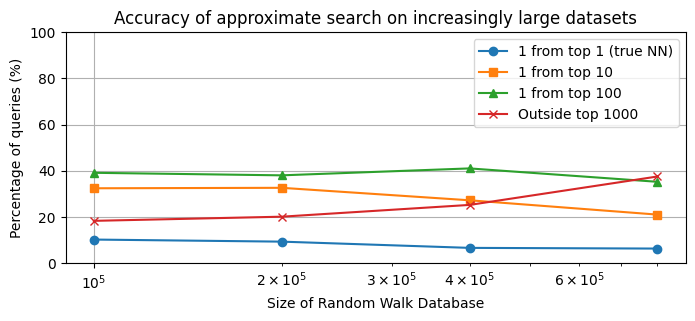

In [17]:
# Plot with x-axis log scaling
plt.figure(figsize=(8, 3))
plt.plot(dataset_sizes, accuracies["top_1"], marker='o', label="1 from top 1 (true NN)")
plt.plot(dataset_sizes, accuracies["top_10"], marker='s', label="1 from top 10")
plt.plot(dataset_sizes, accuracies["top_100"], marker='^', label="1 from top 100")
plt.plot(dataset_sizes, accuracies["outside_1000"], marker='x', label="Outside top 1000")

plt.xlabel("Size of Random Walk Database")
plt.ylabel("Percentage of queries (%)")
plt.xscale('log')
plt.title("Accuracy of approximate search on increasingly large datasets")
plt.legend()
plt.ylim([0, 100])
plt.grid(True)
# plt.savefig('exp2.pdf', format='pdf')
plt.show()